In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'])


In [3]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [4]:
sales_a = sales_a.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_a.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,54555,2738080,177316
1,2019-02-01,54293,4637013,300290
2,2019-03-01,58798,7079920,458491
3,2019-04-01,53229,3744057,242463
4,2019-05-01,50558,4196578,271768


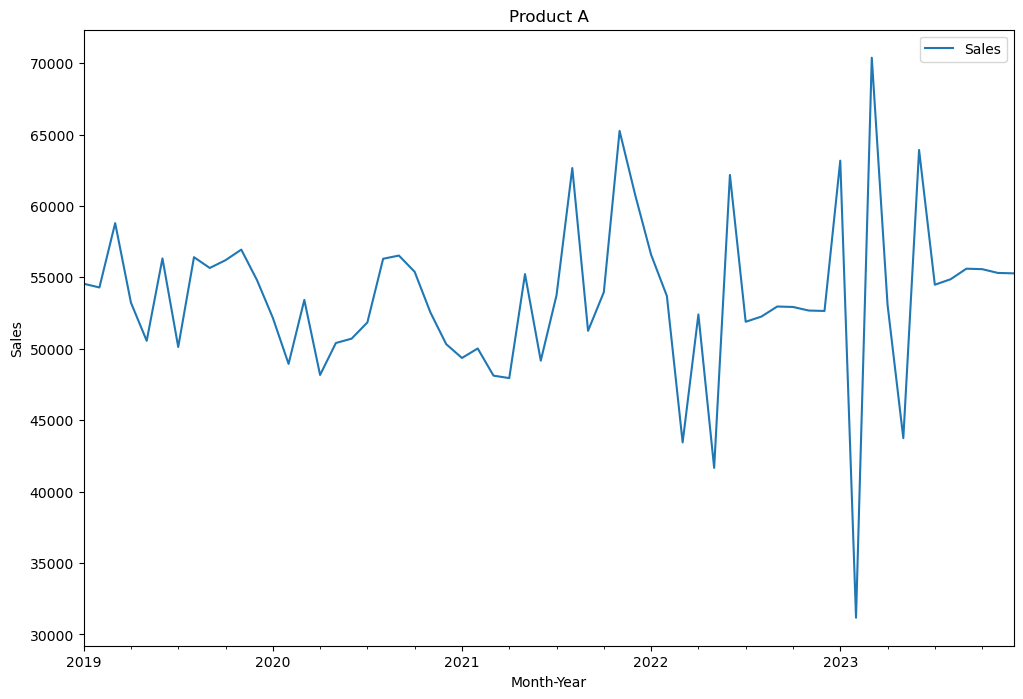

In [5]:
ax = sales_a.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product A')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_a[:48]
test=sales_a[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

20:52:56 - cmdstanpy - INFO - Chain [1] start processing
20:52:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:00 - cmdstanpy - INFO - Chain [1] start processing
20:53:00 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:06 - cmdstanpy - INFO - Chain [1] start processing
20:53:06 - cmdstanpy - INFO - Chain [1] done processing
20:53:09 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:13 - cmdstanpy - INFO - Chain [1] start processing
20:53:15 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:19 - cmdstanpy - INFO - Chain [1] done processing
20:53:22 - cmdstanpy - INFO - Chain [1] start processing
20:53:22 - cmdstanpy - INFO - Chain [1] done processing
20:53:25 - cmdstanpy - INFO - Chain [1] start processing
20:53:26 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0    6426.659145  
1    6626.494087  
2    6045.656271  
3    6176.655701  
4    5918.519621  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
11,0.001,10.00,multiplicative,5825.192537
9,0.001,5.00,multiplicative,5827.647059
18,0.010,3.00,additive,5880.035604
10,0.001,10.00,additive,5902.791393
22,0.010,10.00,additive,5905.524853
...,...,...,...,...
67,0.500,3.00,multiplicative,15604.386124
71,0.500,10.00,multiplicative,15621.552956
49,0.300,0.01,multiplicative,16052.207451
60,0.500,0.01,additive,17340.192363


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=10.0,seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [15]:
future_dates['Market Size'] = sales_a['Market Size']
future_dates['Marketing Expense'] = sales_a['Marketing Expense']

In [16]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [17]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [18]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [19]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,53051.021899,46695.601607,60308.389873
49,2023-02-01,55679.405946,48344.613999,63133.866778
50,2023-03-01,50760.184681,43376.897509,57636.561762
51,2023-04-01,55349.361095,47863.406917,62927.151140
52,2023-05-01,46951.567304,40198.983053,54185.003186
53,2023-06-01,60922.855858,53830.767323,67885.700870
54,2023-07-01,52423.616278,45564.982600,59411.400041
55,2023-08-01,58566.432919,51445.319496,66009.254789
56,2023-09-01,55460.410428,48408.510359,63070.714254
57,2023-10-01,58359.265027,51335.223500,65593.879383


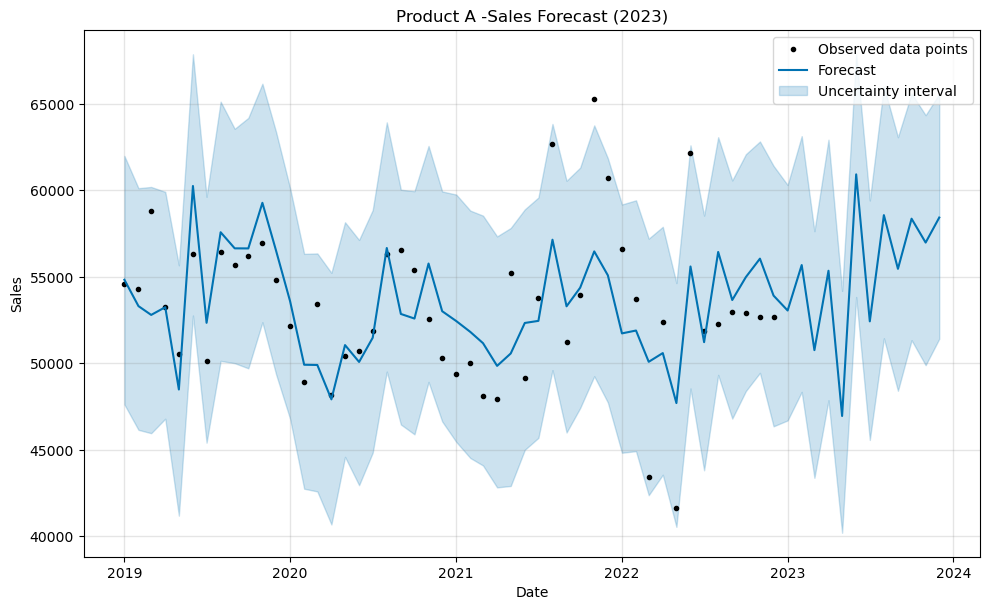

In [20]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

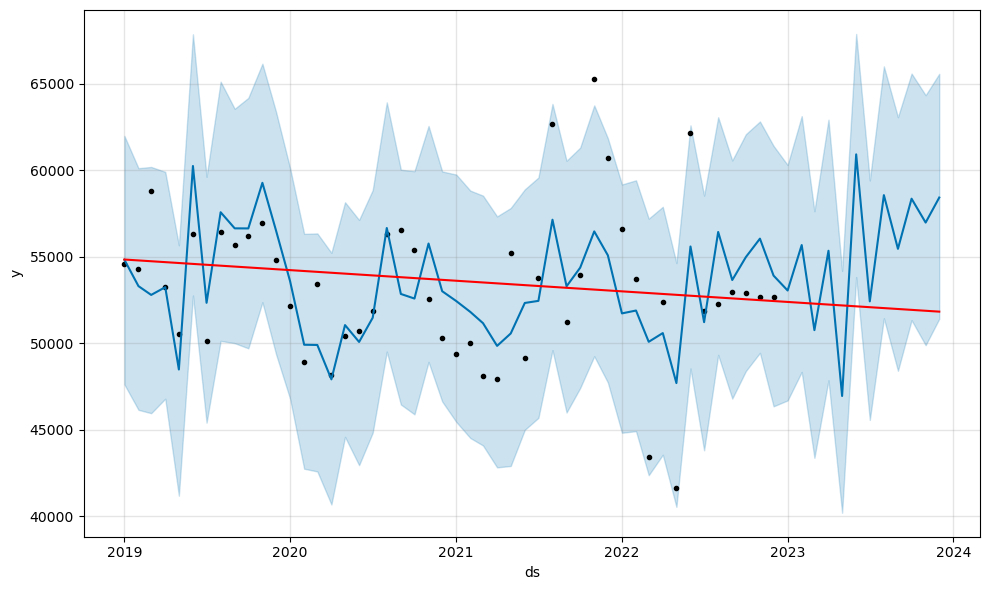

In [21]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

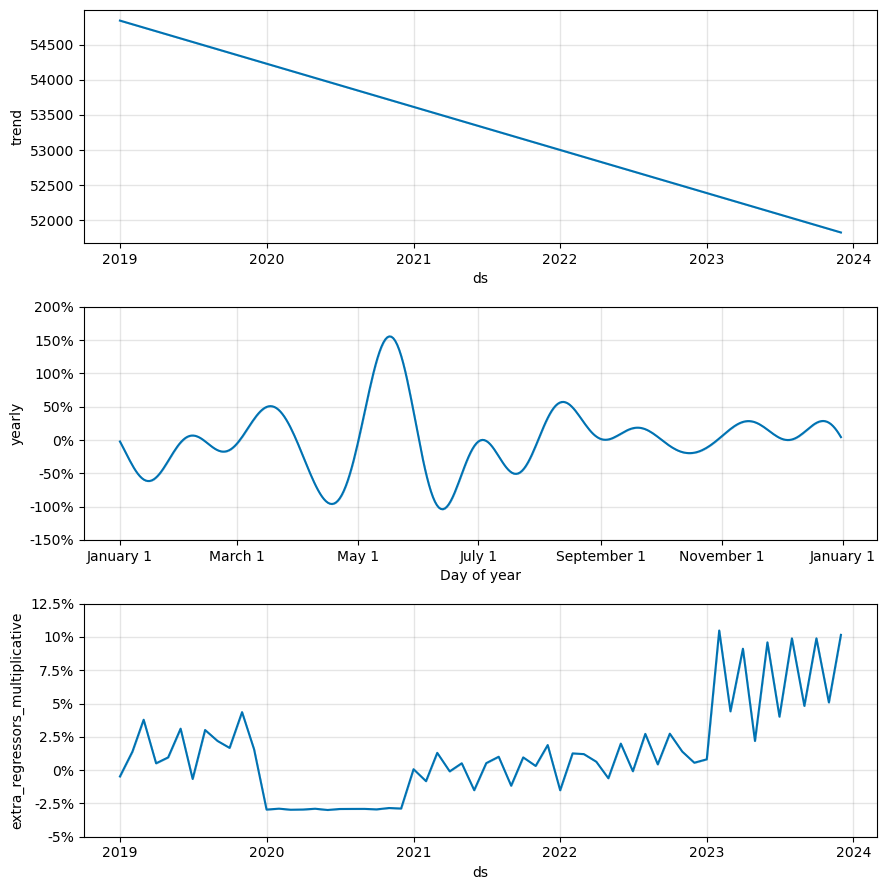

In [22]:
fig2 = model.plot_components(forecast)

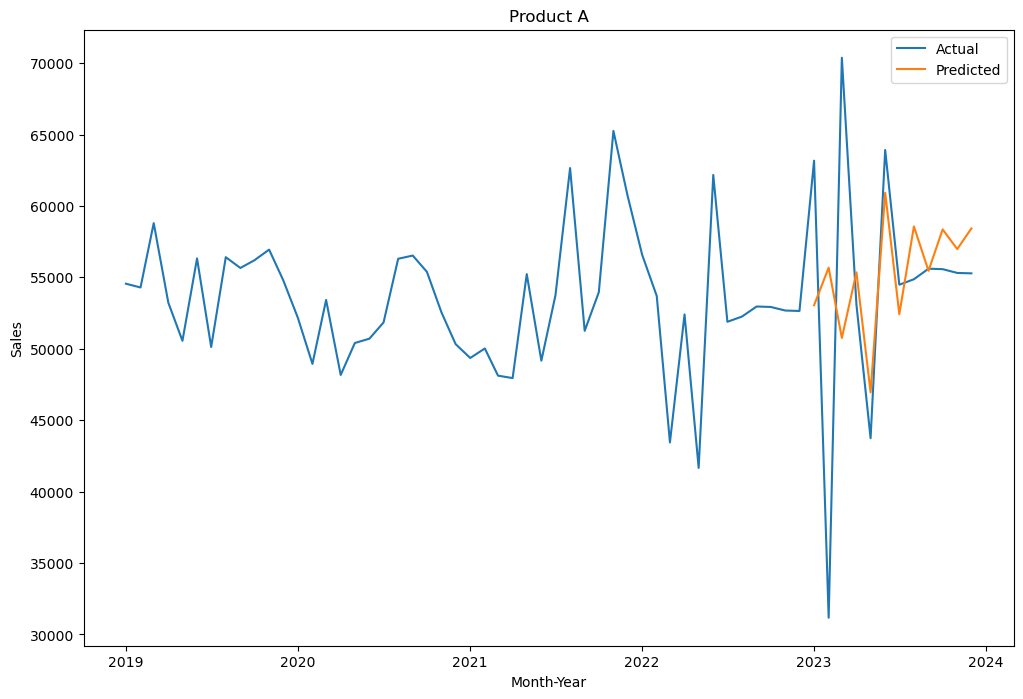

In [23]:
# Reset index of sales_b DataFrame
sales_a_reset_index = sales_a.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_a_reset_index['ds'], sales_a_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product A')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [24]:
#model evaluation

In [25]:
pred=forecasted_df['yhat']
test_df=test['y']

In [26]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 6352.757
MAPE - FB PROPHET: 0.136
MSE - FB PROPHET: 95914666.944
RMSE - FB PROPHET: 9793.603


In [27]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [28]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,2.829966e+07,5319.742307,5319.742307,0.094013,0.094013,0.098651,0.0
1,62 days,3.558631e+05,596.542650,596.542650,0.011109,0.011109,0.011171,1.0
2,90 days,1.089383e+08,10437.350665,10437.350665,0.240259,0.240259,0.214493,0.0
3,121 days,1.122005e+06,1059.247422,1059.247422,0.020213,0.020213,0.020419,1.0
4,151 days,9.313887e+07,9650.848016,9650.848016,0.231669,0.231669,0.207619,0.0
5,182 days,5.540508e+07,7443.458824,7443.458824,0.119724,0.119724,0.127347,0.0
6,212 days,3.722124e+05,610.092129,610.092129,0.011757,0.011757,0.011689,1.0
7,243 days,5.125088e+07,7158.971897,7158.971897,0.136998,0.136998,0.128215,0.0
8,274 days,6.151019e+06,2480.124822,2480.124822,0.046831,0.046831,0.045760,1.0
9,304 days,1.817671e+07,4263.415077,4263.415077,0.080551,0.080551,0.077433,0.0


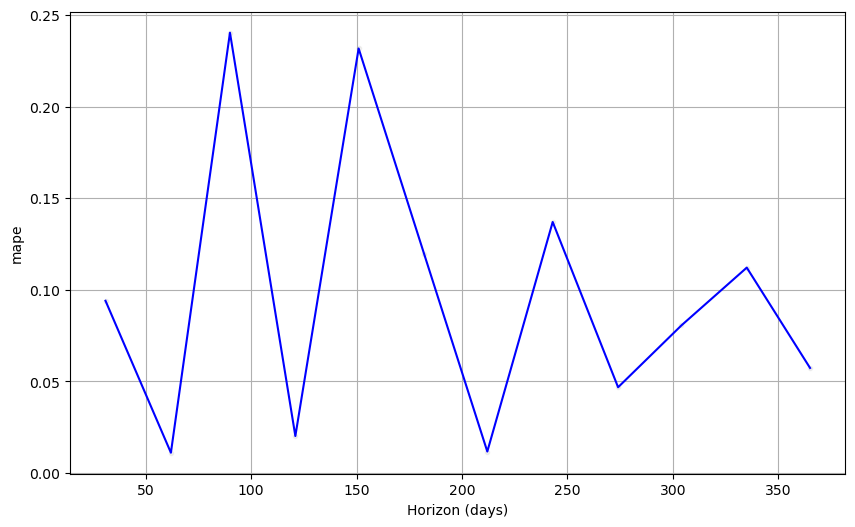

In [29]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [30]:
test_df

48    63171
49    31168
50    70380
51    53078
52    43741
53    63919
54    54485
55    54869
56    55607
57    55575
58    55311
59    55281
Name: y, dtype: int64

In [33]:
pred

48    53051.021899
49    55679.405946
50    50760.184681
51    55349.361095
52    46951.567304
53    60922.855858
54    52423.616278
55    58566.432919
56    55460.410428
57    58359.265027
58    56979.735453
59    58426.402569
Name: yhat, dtype: float64